# Project: Wrangling and Analyze Data

In [135]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
%matplotlib inline


## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [136]:
df= pd.read_csv('twitter-archive-enhanced.csv')
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [137]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
data = requests.get(url)

with open('image-predictions.tsv' , mode='wb') as file:
    file.write(data.content)

In [138]:
image_data = pd.read_csv('image-predictions.tsv', sep='\t')
image_data.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [139]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

ModuleNotFoundError: No module named 'tweepy'

In [140]:
temp = []
import json 

with open('tweet_json.txt', encoding='utf-8') as js_file:
    for i in js_file:
        data = json.loads(i)
        tweet_id = data['id']
        tweet = data['full_text']
        url1 = tweet[tweet.find('https'):]
        favorite_count = data['favorite_count']
        retweet_count = data['retweet_count']  
        retweet_status = data['retweet_status'] = data.get('retweet_status', 'Original tweet')
        if retweet_status == 'Original tweet':
            url = url1
        else:
            retweeted_status = 'A retweet'
            url = 'A retweet'
        
    
        temp.append({'tweet_id': tweet_id,'favorite_count': favorite_count,'retweet_status': retweet_status,
                     'url': url,'retweet_count': retweet_count})

# create a new DataFrame 
df_new = pd.DataFrame(temp, columns = ['tweet_id', 'favorite_count','retweet_count', 'retweet_status', 'url'])
                                          
                                                           
df_new.head()

df_new.to_csv('tweet_json.txt', index=False)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [141]:
print(temp[0])

IndexError: list index out of range

In [142]:
dfj = pd.read_csv('tweet_json.txt')

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [143]:
df.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [144]:
image_data.head(10)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [145]:
dfj.head(10)

,tweet_id,favorite_count,retweet_count,retweet_status,url
0,892420643555336193,39467,8853,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,33819,6514,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,25461,4328,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,42908,8964,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,41048,9774,Original tweet,https://t.co/AtUZn91f7f
5,891087950875897856,20562,3261,Original tweet,https://t.co/kQ04fDDRmh
6,890971913173991426,12041,2158,Original tweet,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl
7,890729181411237888,56848,16716,Original tweet,https://t.co/v0nONBcwxq
8,890609185150312448,28226,4429,Original tweet,https://t.co/9TwLuAGH0b
9,890240255349198849,32467,7711,Original tweet,https://t.co/t1bfwz5S2A


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [147]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [148]:
dfj.info

<bound method DataFrame.info of                 tweet_id  favorite_count  retweet_count  retweet_status  \
0     892420643555336193           39467           8853  Original tweet   
1     892177421306343426           33819           6514  Original tweet   
2     891815181378084864           25461           4328  Original tweet   
3     891689557279858688           42908           8964  Original tweet   
4     891327558926688256           41048           9774  Original tweet   
...                  ...             ...            ...             ...   
2349  666049248165822465             111             41  Original tweet   
2350  666044226329800704             311            147  Original tweet   
2351  666033412701032449             128             47  Original tweet   
2352  666029285002620928             132             48  Original tweet   
2353  666020888022790149            2535            532  Original tweet   

                          url  
0     https://t.co/MgUWQ76dJU  
1  

In [149]:
df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [150]:
dfj.isnull().sum()

tweet_id          0
favorite_count    0
retweet_count     0
retweet_status    0
url               0
dtype: int64

In [151]:
image_data.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [152]:
sum(df.duplicated())

0

In [153]:
sum(dfj.duplicated())

0

In [154]:
sum(image_data.duplicated())

0

In [155]:
image_data.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [156]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [157]:
df_new.describe()

NameError: name 'df_new' is not defined

In [158]:
df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [159]:
dfj.nunique()

tweet_id          2354
favorite_count    2007
retweet_count     1724
retweet_status       1
url               2179
dtype: int64

In [160]:
image_data.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [161]:
np.sort(df['rating_numerator'].unique())

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   20,   24,   26,   27,   44,
         45,   50,   60,   75,   80,   84,   88,   99,  121,  143,  144,
        165,  182,  204,  420,  666,  960, 1776])

In [162]:
np.sort(df['rating_denominator'].unique())

array([  0,   2,   7,  10,  11,  15,  16,  20,  40,  50,  70,  80,  90,
       110, 120, 130, 150, 170])

In [163]:
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [164]:
df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

### Quality issues
1.remove doggo, floofer, pupper, puppo

2.Wrong Datatype img_num Column should be in string

3.The column img_num will be dropped. The reason, why this is an issue of quality: the values in this column do not explain themselves. They therefore might be misinterpreted and should be excluded as a precaution.

4.Change tweet_id from an integer to a string 

5.Timestamp is not of datetime format 

6.Correct column contain some invalid name 

7.Delete retweets 

8.Checking for duplicate values and deleteing them

### Tidiness issues
1.doggo, floofer, pupper, puppo these 4 variables shoule be combined into one categorical variable Dog Type.
and remove columns with too many missing values.

2.merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes .

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [165]:
# Make copies of original pieces of data
twitter = df.copy()
image = image_data.copy()
json = dfj.copy()

### Issue #1:
Merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes .

#### Define:
using pyhton command CONCAT we can merge out datasets


#### Code

In [166]:
df2 = pd.concat([twitter, image, json], join='outer', axis=1)

#### Test
all the three dataset have been merged .


In [167]:
df2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.156665,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.074192,True,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.138584,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.360687,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.243682,True,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,Original tweet,https://t.co/AtUZn91f7f


In [168]:
df2.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'favorite_count', 'retweet_count', 'retweet_status', 'url'],
      dtype='object')

In [169]:
df2.shape

(2356, 34)

### Issue #2:
remove columns with too many missing values 
and doggo, floofer, pupper, puppo these 4 variables shoule be combined into one categorical variable Dog Type.


#### Define
we an delete the column using Command DROP , for column Axis =1
and we can extract the data of the column using .EXTRACT() method

#### Code

In [170]:
df2.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id', 
           'retweeted_status_timestamp'], axis=1, inplace=True)
df2.head()

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,0.156665,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,0.074192,True,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,...,0.138584,True,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,...,0.360687,True,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,...,0.243682,True,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,Original tweet,https://t.co/AtUZn91f7f


#### Test
for testing we can display our dataset using .HEAD() method

##### Define 
we can extract the data of the column using .EXTRACT() method


In [171]:
'''
# Extract the text from the columns into the new dog_type colunn
df2['dog_type'] = df2['text'].str.extract('(doggo|floofer|pupper|puppo)')

'''

"\n# Extract the text from the columns into the new dog_type colunn\ndf2['dog_type'] = df2['text'].str.extract('(doggo|floofer|pupper|puppo)')\n\n"

###### As previously mentioned, there are cases where there are multiple dog stages in a row

In [172]:
df2.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})


,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


In [173]:
df2.doggo.replace('None', '', inplace=True) 
df2.doggo.replace(np.NaN, '', inplace=True)
df2.floofer.replace('None', '', inplace=True) 
df2.floofer.replace(np.NaN, '', inplace=True)
df2.pupper.replace('None', '', inplace=True) 
df2.pupper.replace(np.NaN, '', inplace=True)
df2.puppo.replace('None', '', inplace=True) 
df2.puppo.replace(np.NaN, '', inplace=True)

/Users/raniaalageel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [174]:
df2['dogtype'] = df2.doggo + df2.floofer + df2.pupper + df2.puppo
df2.loc[df2.dogtype == 'doggopupper', 'dog_type'] = 'doggo, pupper'
df2.loc[df2.dogtype == 'doggopuppo', 'dog_type'] = 'doggo, puppo'
df2.loc[df2.dogtype == 'doggofloofer', 'dog_type'] = 'doggo, floofer'

In [175]:
df2.dogtype.value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: dogtype, dtype: int64

In [176]:
df2.dogtype.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [177]:
for idx, row in df2.iterrows():
    if ('doggoNoneNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'doggo'
    elif ('NoneNoneNonepuppo' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'puppo'
    elif ('NoneNonepupperNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'pupper'
    elif ('NoneflooferNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'floofer'
    elif ('NoneNoneNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = None
    else:
        df2.loc[idx, 'dog_type'] = 'multiple'
df2.head()

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url,dogtype,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,NoneNoneNoneNone,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,NoneNoneNoneNone,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,...,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,Original tweet,https://t.co/wUnZnhtVJB,NoneNoneNoneNone,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,...,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,Original tweet,https://t.co/tD36da7qLQ,NoneNoneNoneNone,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,...,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,Original tweet,https://t.co/AtUZn91f7f,NoneNoneNoneNone,None


In [178]:
df2= df2.drop(['dogtype'] , axis =1)

### Test
we can check the values of our newly created column


In [179]:
df2.dog_type.value_counts()

pupper      245
doggo        83
puppo        29
multiple     14
floofer       9
Name: dog_type, dtype: int64

## issue
##### remove doggo, floofer, pupper, puppo

#### Define
 we can delete any column using .DROP() Method
 
 #### code


In [180]:
df2.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)


##### test

check it by diplaying the dataset


In [181]:
df2.head(1)


,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,...,p2_dog,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,6.660209e+17,...,True,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,None


### Quality Issue
The column img_num will be dropped. The reason, why this is an issue of quality: the values in this column do not explain themselves. They therefore might be misinterpreted and should be excluded as a precaution.
### Define
Merging columns rating_numerator and rating_denominator.

### Code

In [182]:
df2['rating'] = df2.rating_numerator / df2.rating_denominator

#Dropping factor columns
columns_to_be_dropped = []
columns_to_be_dropped = ["rating_numerator", "rating_denominator"]
df2.drop(columns_to_be_dropped, axis = 1, inplace=True)
columns_to_be_dropped = []

### Test
###### Check if calculation is correct

In [183]:
df2.rating.value_counts()


1.200000      562
1.100000      469
1.000000      463
1.300000      351
0.900000      157
0.800000      102
0.700000       54
1.400000       54
0.500000       38
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        8
42.000000       2
1.500000        2
0.000000        2
7.500000        2
0.818182        2
1.250000        1
66.600000       1
inf             1
1.700000        1
3.428571        1
0.636364        1
2.700000        1
0.733333        1
2.600000        1
18.200000       1
177.600000      1
Name: rating, dtype: int64

### Quality Issue
Change tweet_id from an integer to a string .
### Define
we can convert the dataype using .ASTYPE() method
### Code

In [184]:
df2['tweet_id'] = df2['tweet_id'].astype(str)


### Test
we can check the datatype using type method

In [185]:
type(df2.iloc[0,0])


str

### Quality Issue
Wrong Datatype Source Column should be in Category
### Define
we can convert the dataype using .ASTYPE() method
### Code

In [186]:
# Changing Data types to appropriate 
df['source'] = df['source'].astype('category')

### Test
we can check the datatype using type method

In [187]:
df2.columns.get_loc("source")

2

In [188]:
df2.source.dtype

dtype('O')

### Quality Issue
Timestamp is not of datetime format .
### Define
for datetime format
%b Month name, short version Dec
%B Month name, full version December
%m Month as a number 01-12 12
%Y Year, full version
%d Day of month 01-31
### Code

In [189]:
# Change the 'timestamp' column to a datetime object
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format = "%Y-%m-%d ")

### Test
we can display some dataset for the testing purpose

In [190]:
df2.head(2)

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,name,tweet_id,jpg_url,img_num,...,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url,dog_type,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,6.660208880227901e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,...,Shetland_sheepdog,0.061428,True,8.924206435553362e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,None,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,6.660292850026209e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,Rhodesian_ridgeback,0.072010,True,8.921774213063434e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,None,1.3


### Quality Issue
Correct name Column it contain some invalid name
### Define
we can replace incorrect names with None using .REPLACE() Method
### Code

In [191]:
df2['name'] = df2.name.replace(['None', 'a', 'an', 'very','the', 'not', 'quite', 'actually'], 'None' , inplace = True)

/Users/raniaalageel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Test
we can check if any row with name equals to these is present or not

In [192]:
df2[df2['name']=='a']

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,name,tweet_id,jpg_url,img_num,...,p3,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,retweet_status,url,dog_type,rating


### Quality Issue
Delete retweets .
### Define
we can delete any column using .DROP() method
### Code

In [193]:
df2 = df2.drop(['retweeted_status_id'] , axis=1)

### Test
we can check if any column named retweeted_status_id is present or not


In [194]:
df2.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'name',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'favorite_count', 'retweet_count', 'retweet_status', 'url', 'dog_type',
       'rating'],
      dtype='object')

### Quality Issue
Checking for duplicate values and deleteing them
### Define
we can check duplicate value using .DUPLICATED method
### Code

In [114]:
df2.drop_duplicates(inplace = True)

### Test
if any value present


In [115]:
df2[df2.duplicated()].sum()

tweet_id          0.0
timestamp         0.0
source            0.0
text              0.0
expanded_urls     0.0
name              0.0
tweet_id          0.0
jpg_url           0.0
img_num           0.0
p1                0.0
p1_conf           0.0
p1_dog            0.0
p2                0.0
p2_conf           0.0
p2_dog            0.0
p3                0.0
p3_conf           0.0
p3_dog            0.0
tweet_id          0.0
favorite_count    0.0
retweet_count     0.0
retweet_status    0.0
url               0.0
dog_type          0.0
rating            0.0
dtype: float64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [116]:
df2.to_csv('twitter_archive_master.csv', encoding='utf-8')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [117]:
df = pd.read_csv('twitter_archive_master.csv')

In [118]:
df.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,name,tweet_id.1,jpg_url,img_num,...,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,url,dog_type,rating
0,0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,NaN,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,...,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,NaN,1.3
1,1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,NaN,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,NaN,1.3
2,2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,NaN,6.660334e+17,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,...,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,Original tweet,https://t.co/wUnZnhtVJB,NaN,1.2
3,3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,NaN,6.660442e+17,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,...,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,Original tweet,https://t.co/tD36da7qLQ,NaN,1.3
4,4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,NaN,6.660492e+17,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,...,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,Original tweet,https://t.co/AtUZn91f7f,NaN,1.2


In [119]:
df.drop(['Unnamed: 0'] , axis = 1 , inplace = True)
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,name,tweet_id.1,jpg_url,img_num,p1,...,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,url,dog_type,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,NaN,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,...,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,NaN,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,...,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,NaN,1.3


In [120]:
df.shape

(2356, 25)

### Insights:
1.Plot between Count of Retweet and Count of Favourites 

2.Plot between Dog type and Image Num vs Favourite Count

3.Plot on Count of Dog Types

4.Plot of count of Image number

### Visualization
Importing our cleaned dataset

In [121]:
df = pd.read_csv('twitter_archive_master.csv')

In [122]:
df.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,name,tweet_id.1,jpg_url,img_num,...,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,url,dog_type,rating
0,0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,NaN,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,...,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,NaN,1.3
1,1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,NaN,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,NaN,1.3
2,2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,NaN,6.660334e+17,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,...,bloodhound,0.116197,True,8.918152e+17,25461.0,4328.0,Original tweet,https://t.co/wUnZnhtVJB,NaN,1.2
3,3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,NaN,6.660442e+17,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,...,miniature_pinscher,0.222752,True,8.916896e+17,42908.0,8964.0,Original tweet,https://t.co/tD36da7qLQ,NaN,1.3
4,4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,NaN,6.660492e+17,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,...,Doberman,0.154629,True,8.913276e+17,41048.0,9774.0,Original tweet,https://t.co/AtUZn91f7f,NaN,1.2


In [123]:
df.drop(['Unnamed: 0'] , axis = 1 , inplace = True)
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,name,tweet_id.1,jpg_url,img_num,p1,...,p3,p3_conf,p3_dog,tweet_id.2,favorite_count,retweet_count,retweet_status,url,dog_type,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,NaN,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,...,Shetland_sheepdog,0.061428,True,8.924206e+17,39467.0,8853.0,Original tweet,https://t.co/MgUWQ76dJU,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,NaN,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,...,Rhodesian_ridgeback,0.072010,True,8.921774e+17,33819.0,6514.0,Original tweet,https://t.co/0Xxu71qeIV,NaN,1.3


In [124]:
df.shape

(2356, 25)

### Insight 1
##### Plot between Count of Retweet and Count of Favourites

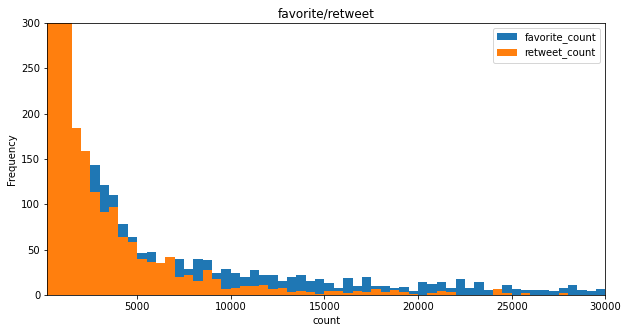

In [125]:
plt.figure(figsize = [10,5])
bins = np.arange(df['favorite_count'].min() , df['favorite_count'].max() + 500, 500)
df.favorite_count.plot(kind='hist',  bins=bins )
bins = np.arange(df['retweet_count'].min() , df['retweet_count'].max() + 500, 500)
df.retweet_count.plot(kind='hist', bins=bins )

plt.xlabel('count')
plt.legend()
plt.xlim(200,30000)
plt.ylim(0,300)
plt.title( 'favorite/retweet');


#### Observation 
it is clearly shown that the counts of favourites are more than the counts of retweet 

### Insight 2
Plot between Dog type and Image Num vs Favourite Count

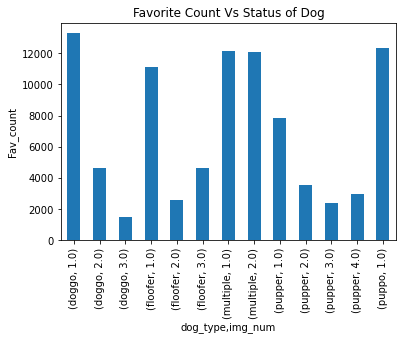

In [126]:
count = df.groupby(['dog_type','img_num']).favorite_count.mean()
count.plot(kind='bar')
plt.ylabel('Fav_count')
plt.title('Favorite Count Vs Status of Dog');

#### Observation 
Image 1 have highest sample size among all the images , also Pupper type dog having more favourite counts .

### Insight 3
##### Plot on Count of Dog Types.

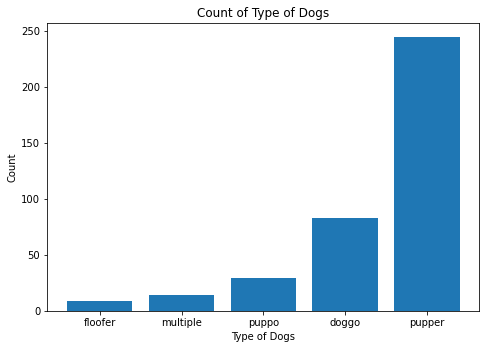

In [127]:
count=list(df['dog_type'].value_counts().sort_values())
label=list(df['dog_type'].value_counts().sort_values().index)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label,count)
plt.xlabel("Type of Dogs")
plt.ylabel("Count")
ax.set_title("Count of Type of Dogs")
plt.show()

#### Observation 
we can clearly see that the most famous dog type is PUPPER followed by Doggo

### Insight 4
##### Plot of count of Image number.

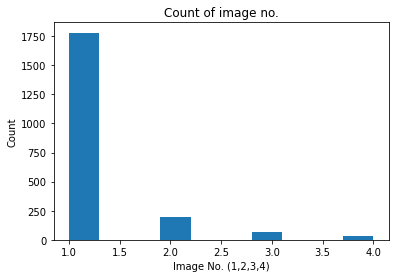

In [128]:
plt.hist(data =df , x='img_num')
plt.xlabel('Image No. (1,2,3,4)')
plt.ylabel('Count')
plt.title('Count of image no.');

### Reviewd Solution 
since img_num is not a continuous variable, it is more appropriate to use a bar graph than a histogram

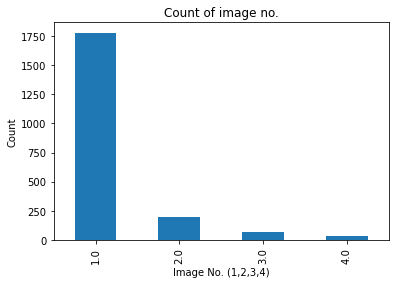

In [129]:
g = df['img_num'].value_counts()
g.plot(kind='bar')
plt.xlabel('Image No. (1,2,3,4)')
plt.ylabel('Count')
plt.title('Count of image no.');


### Observation 
clearly the Image Number one is the most frequent image 




# Rania Alageel